In [1]:
import pandas as pd
import numpy as np
import re
import os
import json
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from nltk.stem import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from wordcloud import WordCloud
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Code for fetching the dataset from kaggle (for colab environment, if the dataset is not avaiable locally):

In [2]:
# !mkdir ~/.kaggle
# !touch ~/.kaggle/kaggle.json

# api_token = {"username":"leylaeminova","key":"1208531f4079d9b739761ed6f33dceb1"}


# with open('/root/.kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !chmod 600 ~/.kaggle/kaggle.json

# from kaggle.api.kaggle_api_extended import KaggleApi

# def fetch_dataset(dataset_slug, destination_dir='./', unzip=True):

#     os.environ['KAGGLE_USERNAME'] = 'leylaeminova'
#     os.environ['KAGGLE_KEY'] = '1208531f4079d9b739761ed6f33dceb1'

#     api = KaggleApi()
#     api.authenticate()

#     try:
#         api.dataset_download_files(dataset_slug, path=destination_dir, unzip=unzip)

#         files = os.listdir(destination_dir)

#         return files

#     except Exception as e:
#         print(f"Error downloading dataset: {str(e)}")
#         return []


# dataset_slug = 'suraj520/customer-support-ticket-dataset'
# destination_directory = './dataset'

# downloaded_files = fetch_dataset(dataset_slug, destination_directory)

# if downloaded_files:
#     print(f"Download successful. Files: {downloaded_files}")
# else:
#     print("Download failed.")

#### Reading the dataset and getting familiar with it

In [3]:
data = pd.read_csv('customer_support_tickets.csv')
data.head()

,Ticket ID,Customer Name,Customer Email,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0


In [4]:
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], format = '%Y-%m-%d') # fixing the date formats
data['First Response Time'] = pd.to_datetime(data['First Response Time'], format = '%Y-%m-%d %H:%M:%S')
data['Time to Resolution'] = pd.to_datetime(data['Time to Resolution'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Ticket ID                     8469 non-null   int64         
 1   Customer Name                 8469 non-null   object        
 2   Customer Email                8469 non-null   object        
 3   Customer Age                  8469 non-null   int64         
 4   Customer Gender               8469 non-null   object        
 5   Product Purchased             8469 non-null   object        
 6   Date of Purchase              8469 non-null   datetime64[ns]
 7   Ticket Type                   8469 non-null   object        
 8   Ticket Subject                8469 non-null   object        
 9   Ticket Description            8469 non-null   object        
 10  Ticket Status                 8469 non-null   object        
 11  Resolution                    

In [6]:
data.isnull().sum()

Ticket ID                          0
Customer Name                      0
Customer Email                     0
Customer Age                       0
Customer Gender                    0
Product Purchased                  0
Date of Purchase                   0
Ticket Type                        0
Ticket Subject                     0
Ticket Description                 0
Ticket Status                      0
Resolution                      5700
Ticket Priority                    0
Ticket Channel                     0
First Response Time             2819
Time to Resolution              5700
Customer Satisfaction Rating    5700
dtype: int64

#### Data Cleaning

Filling the missing vairables with "None"

In [7]:
def fill_nulls_with_none(dataset):
    """
    Fill null values in all columns of the dataset with "None".
    
    Parameters:
        dataset (pd.DataFrame): Input DataFrame.
        
    Returns:
        pd.DataFrame: DataFrame with null values filled with "None".
    """

    dataset_filled = dataset.apply(lambda col: col.fillna("None"))

    return dataset_filled

data = fill_nulls_with_none(data)
     

Dropping unnecessary features

In [8]:
data.drop(['Ticket ID','Customer Name', 'Customer Email'], axis = 1, inplace = True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Customer Age                  8469 non-null   int64         
 1   Customer Gender               8469 non-null   object        
 2   Product Purchased             8469 non-null   object        
 3   Date of Purchase              8469 non-null   datetime64[ns]
 4   Ticket Type                   8469 non-null   object        
 5   Ticket Subject                8469 non-null   object        
 6   Ticket Description            8469 non-null   object        
 7   Ticket Status                 8469 non-null   object        
 8   Resolution                    8469 non-null   object        
 9   Ticket Priority               8469 non-null   object        
 10  Ticket Channel                8469 non-null   object        
 11  First Response Time           

#### EDA

Most of the customers are middle aged

In [10]:
age = []
for i in data['Customer Age']:
    if i<=30:
        age.append('Young')
    elif 30<i<55:
        age.append('Middle Age')
    else:
        age.append('Senior')
data['Age Classification'] = age

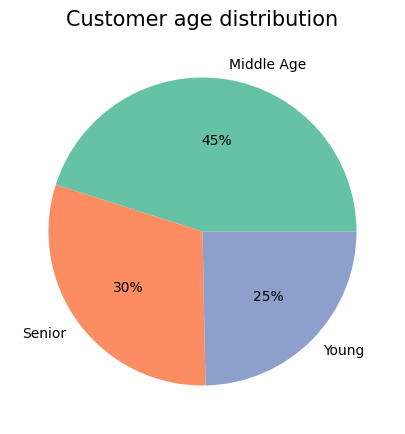

In [11]:
chart_age = data['Age Classification'].value_counts()
chart_gen = data['Customer Gender'].value_counts()
plt.figure(figsize = (10,5))
plt.pie(chart_age, labels = chart_age.index, autopct='%.0f%%', colors = sns.color_palette('Set2'))
plt.title('Customer age distribution', loc = 'center', pad = 10, size = 15)
plt.show()

In [12]:
data_ticket = data[['Ticket Subject', 'Ticket Description', 'Ticket Type']]

#### Checking the distribution of target column

Text(0.5, 1.0, 'Distribution of Target')

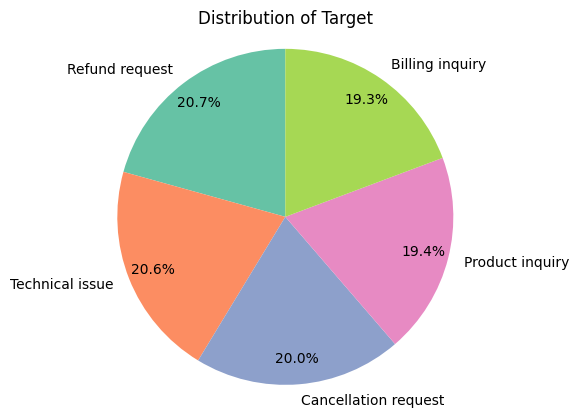

In [13]:
ticket_types = data_ticket['Ticket Type'].value_counts()

categories = ticket_types.index
counts = ticket_types.values


plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90, pctdistance=0.85, colors=sns.color_palette('Set2'))
fig = plt.gcf()

plt.axis('equal')
plt.title('Distribution of Target')

# plt.legend(categories, title='Classes', loc='upper left')

#### Feature Engineering

Cleaning unnecessary characters and symbols from the text

In [14]:
data_ticket = data[['Ticket Subject', 'Ticket Description', 'Ticket Type']]
def clean_text(text):
    """
    Clean and preprocess a single text string.
    
    Parameters:
        text (str): Input text to clean.
        
    Returns:
        str: Cleaned text.
    """
    text = str(text).lower()
    text = re.sub(r'\n', ' ', text)  # Remove newline characters
    text = re.sub(r'\t', ' ', text)  # Remove tab characters
    text = re.sub(r'{.*?}', '', text)  # Remove between {}
    text = re.sub(r'\([^)]*\)', '', text)  # Remove between ()
    text = re.sub(r' +', ' ', text)  # Remove multiple space with single

    return text

In [15]:
data_ticket['Ticket Description'] = data_ticket['Ticket Description'].apply(lambda x:clean_text(x))

In [16]:
data_ticket['Ticket Description'] 

0       i'm having an issue with the . please assist. ...
1       i'm having an issue with the . please assist. ...
2       i'm facing a problem with my . the is not turn...
3       i'm having an issue with the . please assist. ...
4       i'm having an issue with the . please assist. ...
                              ...                        
8464    my is making strange noises and not functionin...
8465    i'm having an issue with the . please assist. ...
8466    i'm having an issue with the . please assist. ...
8467    i'm having an issue with the . please assist. ...
8468    there seems to be a hardware problem with my ....
Name: Ticket Description, Length: 8469, dtype: object

In [17]:
def remove_stopwords(text):
    """
    Tokenize a single text string into words.
    
    Parameters:
        text (str): Input text to tokenize.
        
    Returns:
        list: List of tokens (words).
    """
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english'))
    return text

data_ticket['Ticket Description'] = data_ticket['Ticket Description'].apply(lambda x:remove_stopwords(x))

In [18]:
flattened_tokens = [token for sequence in data_ticket['Ticket Description'] for token in sequence]

# Find the vocabulary size (number of unique tokens)
vocab_size = len(set(flattened_tokens))

print("Vocabulary Size:", vocab_size)

Vocabulary Size: 117


In [19]:
sequence_lengths = [len(sequence) for sequence in data_ticket['Ticket Description']]

# Find the maximum length of input sequences
max_length_of_input = max(sequence_lengths)

print("Maximum Length of Input:", max_length_of_input)

Maximum Length of Input: 307


In [20]:
data_ticket['Ticket Description']

0       i'm issue . please assist. billing zip code is...
1       i'm issue . please assist. need change existin...
2       i'm facing problem . turning on. working fine ...
3       i'm issue . please assist. problem interested ...
4       i'm issue . please assist. note: seller respon...
                              ...                        
8464    making strange noises functioning properly. su...
8465    i'm issue . please assist. sell 30-35% . buy 8...
8466    i'm issue . please assist. using different bro...
8467    i'm issue . please assist. think product categ...
8468    seems hardware problem . screen flickering, i'...
Name: Ticket Description, Length: 8469, dtype: object

In [21]:
def visualize_common_words(data):
    text = ' '.join(data['Ticket Description'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

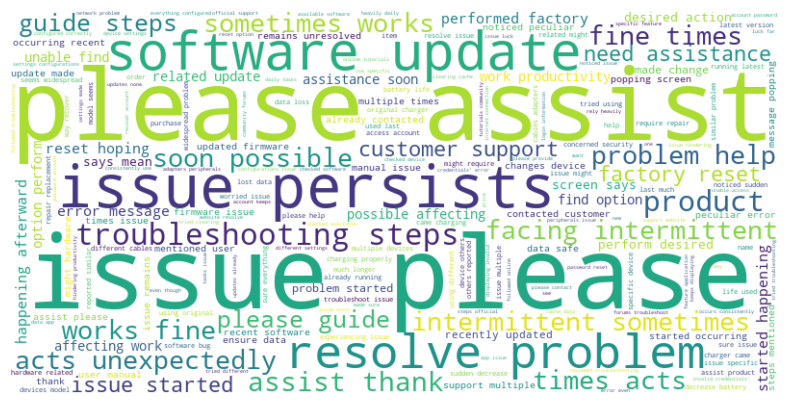

In [22]:
visualize_common_words(data_ticket)

In [23]:
def tokenize_column(data, column_name):
    """
    Tokenize the values in a specified column of the DataFrame.
    
    Parameters:
        data (pd.DataFrame): Input DataFrame.
        column_name (str): Name of the column to tokenize.
        
    Returns:
        pd.Series: Series containing tokenized values.
    """
    data['Tokenized words'] = data[column_name].apply(nltk.word_tokenize)
    
    return data
data_ticket = tokenize_column(data_ticket, 'Ticket Description')

In [24]:
data_ticket['Ticket Description']

0       i'm issue . please assist. billing zip code is...
1       i'm issue . please assist. need change existin...
2       i'm facing problem . turning on. working fine ...
3       i'm issue . please assist. problem interested ...
4       i'm issue . please assist. note: seller respon...
                              ...                        
8464    making strange noises functioning properly. su...
8465    i'm issue . please assist. sell 30-35% . buy 8...
8466    i'm issue . please assist. using different bro...
8467    i'm issue . please assist. think product categ...
8468    seems hardware problem . screen flickering, i'...
Name: Ticket Description, Length: 8469, dtype: object

In [25]:
def stem_words(dataset, column):
    stemmer = PorterStemmer()
    dataset['Stemmed Token'] = dataset[column].apply(lambda words : [stemmer.stem(word) for word in words])
    dataset['Stemmed Token'] = dataset['Stemmed Token'].apply(lambda x : ' '.join(x))
    return dataset

data_ticket = stem_words(data_ticket, 'Tokenized words')

In [26]:
data_ticket

,Ticket Subject,Ticket Description,Ticket Type,Tokenized words,Stemmed Token
0,Product setup,i'm issue . please assist. billing zip code is...,Technical issue,"[i, 'm, issue, ., please, assist, ., billing, ...",i 'm issu . pleas assist . bill zip code is : ...
1,Peripheral compatibility,i'm issue . please assist. need change existin...,Technical issue,"[i, 'm, issue, ., please, assist, ., need, cha...",i 'm issu . pleas assist . need chang exist pr...
2,Network problem,i'm facing problem . turning on. working fine ...,Technical issue,"[i, 'm, facing, problem, ., turning, on, ., wo...",i 'm face problem . turn on . work fine yester...
3,Account access,i'm issue . please assist. problem interested ...,Billing inquiry,"[i, 'm, issue, ., please, assist, ., problem, ...",i 'm issu . pleas assist . problem interest i ...
4,Data loss,i'm issue . please assist. note: seller respon...,Billing inquiry,"[i, 'm, issue, ., please, assist, ., note, :, ...",i 'm issu . pleas assist . note : seller respo...
...,...,...,...,...,...
8464,Installation support,making strange noises functioning properly. su...,Product inquiry,"[making, strange, noises, functioning, properl...",make strang nois function properli . suspect m...
8465,Refund request,i'm issue . please assist. sell 30-35% . buy 8...,Technical issue,"[i, 'm, issue, ., please, assist, ., sell, 30-...",i 'm issu . pleas assist . sell 30-35 % . buy ...
8466,Account access,i'm issue . please assist. using different bro...,Technical issue,"[i, 'm, issue, ., please, assist, ., using, di...",i 'm issu . pleas assist . use differ browser ...
8467,Payment issue,i'm issue . please assist. think product categ...,Product inquiry,"[i, 'm, issue, ., please, assist, ., think, pr...",i 'm issu . pleas assist . think product categ...


#### Defining a model & Training

First, I start by trying a simple classification model, logistic regression. I tried its performance only with ticket description column, which resulted in poor performance. Then, I tried combining vectorized description column with encoded ticket subject column. As performance did not change, I tried different, more complex models.

In [27]:
vectorizer = TfidfVectorizer(max_features = 25000) # creating a bag of words matrix using the Tfidf Vectorizer

In [28]:
label_encoder = LabelEncoder()
data_ticket['Ticket type encoded'] = label_encoder.fit_transform(data_ticket['Ticket Type']) # encoding the target variable
data_ticket['Ticket Subject encoded'] = label_encoder.fit_transform(data_ticket['Ticket Subject']) # encoding ticket subject variable

In [29]:
x = data_ticket[['Stemmed Token', 'Ticket Subject encoded']]
y = data_ticket[['Ticket type encoded']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=42)

# fit the TfidfVectorizer on the training data
vectorizer.fit(x_train['Stemmed Token'])

# transform both training and testing data with the same vectorizer
x_train_transformed = vectorizer.transform(x_train['Stemmed Token'])
x_test_transformed = vectorizer.transform(x_test['Stemmed Token'])

In [30]:
# creating the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# fit the model
model.fit(x_train_transformed, y_train)

# make predictions
y_pred = model.predict(x_test_transformed)

# evaluate the accuracy
acc1 = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression Model: {acc1}")

Accuracy of Logistic Regression Model: 0.18693427784336875


In [31]:
# Creating new train and test sets for the combined model
X_train_subjects, X_test_subjects, y_train, y_test = train_test_split(
    data_ticket['Ticket Subject encoded'].values.reshape(-1, 1), data_ticket['Ticket type encoded'], test_size=0.3, random_state=42)
X_train_tfidf = vectorizer.transform(x_train['Stemmed Token'])
X_test_tfidf = vectorizer.transform(x_test['Stemmed Token'])

#Concatenate the encoded subject features and TF-IDF vectorized descriptions
X_train_combined = hstack([X_train_subjects, X_train_tfidf])
X_test_combined = hstack([X_test_subjects, X_test_tfidf])


In [32]:
# creating the model
lr_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# fit the model
model.fit(X_train_combined, y_train)

# make predictions
lr_predictions = model.predict(X_test_combined)

# evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions)

print("\nLogistic Regression Classifier:")
print("Accuracy:", lr_accuracy)
print("Classification Report:")
print(lr_report)


Logistic Regression Classifier:
Accuracy: 0.18732782369146006
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.12      0.14       528
           1       0.17      0.19      0.18       488
           2       0.19      0.19      0.19       481
           3       0.20      0.22      0.21       520
           4       0.20      0.22      0.21       524

    accuracy                           0.19      2541
   macro avg       0.19      0.19      0.19      2541
weighted avg       0.19      0.19      0.19      2541



In [33]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_combined, y_train)

# Predict on the test set
nb_predictions = nb_classifier.predict(X_test_combined)

# Evaluate Multinomial Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions)

print("\nMultinomial Naive Bayes Classifier:")
print("Accuracy:", nb_accuracy)
print("Classification Report:")
print(nb_report)


Multinomial Naive Bayes Classifier:
Accuracy: 0.19637937819756002
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.04      0.06       528
           1       0.18      0.16      0.17       488
           2       0.18      0.13      0.15       481
           3       0.20      0.30      0.24       520
           4       0.21      0.35      0.26       524

    accuracy                           0.20      2541
   macro avg       0.19      0.20      0.18      2541
weighted avg       0.19      0.20      0.18      2541



In [34]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_combined, y_train)

rf_predictions = rf_classifier.predict(X_test_combined)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print("Random Forest Classifier:")
print("Accuracy:", rf_accuracy)
print("Classification Report:")
print(rf_report)

Random Forest Classifier:
Accuracy: 0.20031483667847305
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.16      0.18       528
           1       0.19      0.22      0.20       488
           2       0.17      0.16      0.16       481
           3       0.23      0.26      0.24       520
           4       0.20      0.21      0.21       524

    accuracy                           0.20      2541
   macro avg       0.20      0.20      0.20      2541
weighted avg       0.20      0.20      0.20      2541



In [35]:
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train_combined, y_train)

svm_predictions = svm_classifier.predict(X_test_combined)

svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions)

print("\nSupport Vector Machine Classifier:")
print("Accuracy:", svm_accuracy)
print("Classification Report:")
print(svm_report)


Support Vector Machine Classifier:
Accuracy: 0.18929555293191658
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.11      0.14       528
           1       0.18      0.22      0.20       488
           2       0.17      0.15      0.16       481
           3       0.21      0.23      0.22       520
           4       0.20      0.23      0.22       524

    accuracy                           0.19      2541
   macro avg       0.19      0.19      0.19      2541
weighted avg       0.19      0.19      0.19      2541



Still, the performance did not improve. The reason could be our train data has a lot of rows and just two columns. I can try using other columns, but as it is not specified in task, I'll try different approch. A deep learning model could perform much better on this kind of data. 

In [36]:
model = Sequential()
model.add(Embedding(input_dim=200, output_dim=50, input_length=307))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_combined, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_combined, y_test)
print('Test Accuracy:', accuracy)

Epoch 1/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 90s 591ms/step - accuracy: 0.2045 - loss: 1.6243 - val_accuracy: 0.2201 - val_loss: 1.6085
Epoch 2/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 91s 612ms/step - accuracy: 0.1977 - loss: 1.6092 - val_accuracy: 0.2083 - val_loss: 1.6082
Epoch 3/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 91s 611ms/step - accuracy: 0.2072 - loss: 1.6091 - val_accuracy: 0.2083 - val_loss: 1.6081
Epoch 4/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 89s 597ms/step - accuracy: 0.2078 - loss: 1.6092 - val_accuracy: 0.2083 - val_loss: 1.6080
Epoch 5/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 91s 608ms/step - accuracy: 0.2039 - loss: 1.6093 - val_accuracy: 0.2083 - val_loss: 1.6079
Epoch 6/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 112s 753ms/step - accuracy: 0.2098 - loss: 1.6088 - val_accuracy: 0.2083 - val_loss: 1.6077
Epoch 7/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 94s 632ms/step - accuracy: 0.2159 - loss: 1.6083 - val_accuracy: 0.2083 - val_loss: 1.6079
Epoch 8/10
149/149 ━━━━━━━━━━━━━━━━━━━━ 93s 620ms/step - accuracy: 0.1936 - loss: 

As the accuracy is too low, hyperparameter tuning can not really change much. Still, the code for hyperparameter tuning for the last model (can be adjusted by changing parameters for each model):

In [37]:
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'filters1': [64, 128],
#     'filters2': [32, 64],
#     'kernel_size': [3, 5],
#     'dropout_rate': [0.3, 0.5]
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(X_train_combined, y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))